==== WORLD RAY ====
 origin   = [-2.  -1.5 -1. ]
 terminus = [ 3.20789 -0.84901  0.95296]
 direction (world) = [5.20789 0.65099 1.95296]
 length   = 5.6
 cone_len_world = 0.33599999999999997 , t_cone_base_world = 0.94
 INTERSECTION: t_entry = 0.1770034278906497 , t_exit = 0.592853134614423
  entry_pt = [-1.07818 -1.38477 -0.65432]
  exit_pt  = [ 1.08752 -1.11406  0.15782]

==== WHITENED RAY ====
 o' (full)        = [0.03644 0.03418 1.47377]
 d' (full)        = [-1.64501  0.35882 -2.89096]
 d' (plotted)     = [-2.05626  0.44852 -3.6137 ]
 plotted terminus'= [-2.01982  0.48271 -2.13993]
 plotted length   = 4.181888250024941
 cone_len_white (numeric) = 0.33599999999999997 , t_cone_base_white = 0.9196535201537257


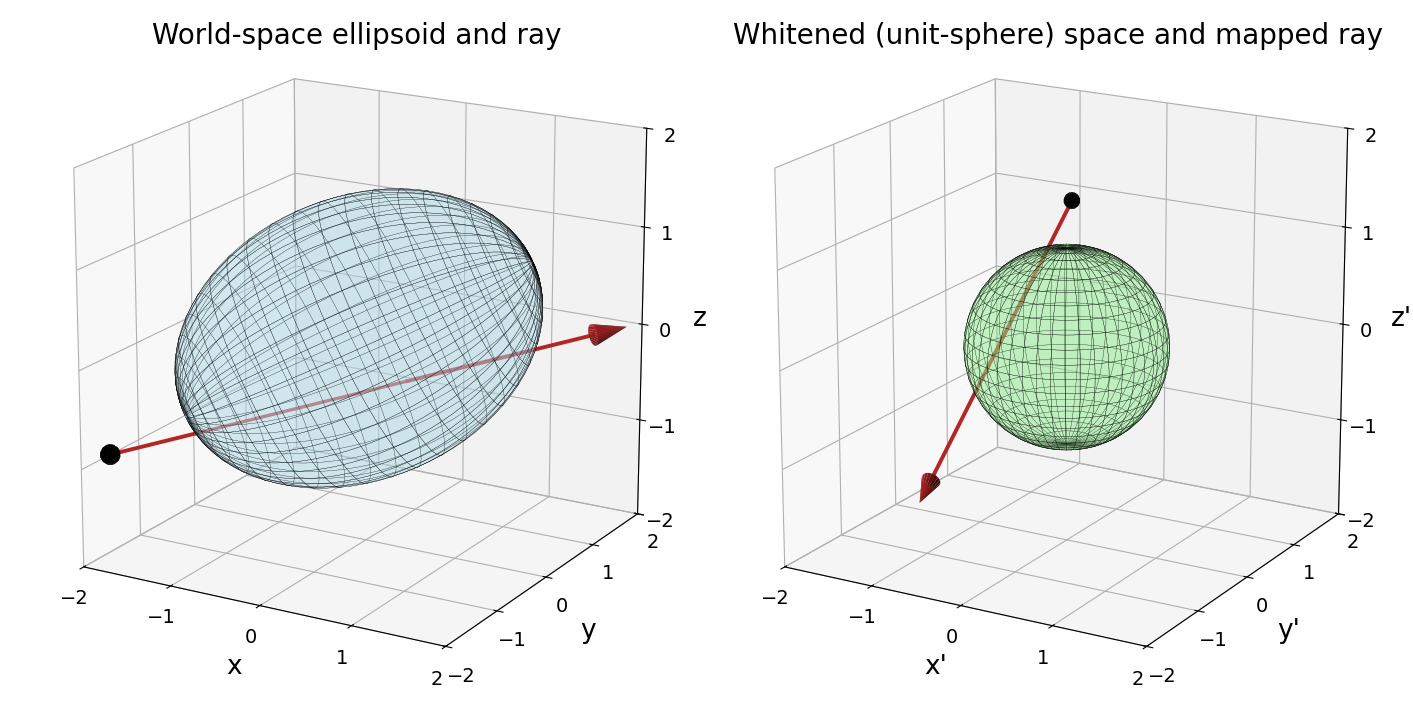

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mu = np.array([0.2, -0.5, 0.25])
Sigma = np.array([[1.0, 0.3, 0.2],
                  [0.3, 0.5, 0.1],
                  [0.2, 0.1, 0.8]])

R = 3.0     
size_scale = 0.55

ray_origin = np.array([-2.0, -1.5, -1.0])    

# ray_terminus = np.array([1.1, 0.2, 0.6])
ray_terminus = None

direction_point = np.array([2.0, -1.0, 0.5])
ray_length = 5.6

azim, elev = -60, 18
axis_limit = 2.0
camera_dot_radius_world = 0.1
camera_dot_radius_white = 0.08
arrow_color = "firebrick"
white_length_scale = 1.25

ARROW_HEAD_LENGTH_FRAC = 0.06
ARROW_HEAD_RADIUS_FRAC = 0.3
ARROW_HEAD_MIN_LENGTH = 0.02
ARROW_HEAD_RESOLUTION = 32


Sigma = Sigma * (size_scale ** 2)

# ----------------------------- Helper functions ---------------------------
def ellipsoid_surface(mu, Sigma, R=3.0, nu=80, nv=40):
    vals, vecs = np.linalg.eigh(Sigma)
    radii = R * np.sqrt(np.maximum(vals, 0.0))
    u = np.linspace(0, 2*np.pi, nu)
    v = np.linspace(0, np.pi, nv)
    xu = np.outer(np.cos(u), np.sin(v))
    yu = np.outer(np.sin(u), np.sin(v))
    zu = np.outer(np.ones_like(u), np.cos(v))
    unit_pts = np.stack([xu.ravel(), yu.ravel(), zu.ravel()], axis=1)
    mapped = (vecs @ (np.diag(radii) @ unit_pts.T)).T + mu[None, :]
    X = mapped[:,0].reshape(xu.shape)
    Y = mapped[:,1].reshape(xu.shape)
    Z = mapped[:,2].reshape(xu.shape)
    return X, Y, Z

def unit_sphere_surface(nu=80, nv=40):
    u = np.linspace(0, 2*np.pi, nu)
    v = np.linspace(0, np.pi, nv)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    return x, y, z

def small_sphere(ax, center, radius=0.05, color='k', nu=16, nv=8):
    u = np.linspace(0, 2*np.pi, nu)
    v = np.linspace(0, np.pi, nv)
    x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radius * np.outer(np.ones_like(u), np.cos(v)) + center[2]
    ax.plot_surface(x, y, z, color=color, linewidth=0, shade=True)

def plot_segment(ax, origin, direction, t0, t1, n=120, **plot_kwargs):
    if t1 <= t0:
        return
    ts = np.linspace(t0, t1, n)
    pts = origin[None,:] + ts[:,None] * direction[None,:]
    ax.plot(pts[:,0], pts[:,1], pts[:,2], **plot_kwargs)

def draw_cone_arrow(ax, base_point, tip_point, color='firebrick',
                    head_radius_frac=0.25, n_theta=28, alpha=1.0):
    v = tip_point - base_point
    L = np.linalg.norm(v)
    if L < 1e-12:
        return
    cone_tip = tip_point
    cone_base = base_point
    v_unit = v / (np.linalg.norm(v) + 1e-20)

    arbitrary = np.array([0.0, 0.0, 1.0])
    if abs(np.dot(arbitrary, v_unit)) > 0.999:
        arbitrary = np.array([0.0, 1.0, 0.0])
    u1 = np.cross(v_unit, arbitrary); u1 /= (np.linalg.norm(u1) + 1e-20)
    u2 = np.cross(v_unit, u1); u2 /= (np.linalg.norm(u2) + 1e-20)

    radius = head_radius_frac * L
    thetas = np.linspace(0.0, 2*np.pi, n_theta, endpoint=False)
    circle_pts = (cone_base[None,:] +
                  np.cos(thetas)[:,None] * (u1[None,:] * radius) +
                  np.sin(thetas)[:,None] * (u2[None,:] * radius))

    verts = np.vstack([circle_pts, cone_tip[None,:]])
    triangles = []
    tip_idx = verts.shape[0] - 1
    for i in range(n_theta):
        i2 = (i + 1) % n_theta
        triangles.append([i, i2, tip_idx])
    triangles = np.array(triangles)
    ax.plot_trisurf(verts[:,0], verts[:,1], verts[:,2], triangles=triangles,
                    color=color, linewidth=0.0, shade=True, alpha=alpha)

if ray_terminus is not None:
    ray_terminus = np.asarray(ray_terminus, dtype=float)
    ray_dir_world = ray_terminus - ray_origin
    ray_world_length = np.linalg.norm(ray_dir_world)
else:
    direction_point = np.asarray(direction_point, dtype=float)
    ray_direction = direction_point - ray_origin
    norm_dir = np.linalg.norm(ray_direction)
    if norm_dir < 1e-12:
        raise ValueError("direction_point coincides with ray_origin or is too close.")
    ray_direction_unit = ray_direction / norm_dir
    ray_dir_world = ray_direction_unit * float(ray_length)
    ray_world_length = float(ray_length)
    ray_terminus = ray_origin + ray_dir_world

if ray_world_length < 1e-12:
    raise ValueError("Ray length is zero.")

Sigma_inv = np.linalg.inv(Sigma)
oc = ray_origin - mu
d = ray_dir_world
A = float(d @ (Sigma_inv @ d))
B = 2.0 * float(d @ (Sigma_inv @ oc))
C = float(oc @ (Sigma_inv @ oc) - R**2)

intersects = False
t_entry, t_exit = None, None
if abs(A) >= 1e-12:
    disc = B*B - 4*A*C
    if disc >= 0.0:
        r1 = (-B - np.sqrt(disc)) / (2*A)
        r2 = (-B + np.sqrt(disc)) / (2*A)
        t0, t1 = sorted([r1, r2])
        t_entry = max(t0, 0.0)
        t_exit  = min(t1, 1.0)
        if t_entry <= t_exit:
            intersects = True

vals, vecs = np.linalg.eigh(Sigma)
vals_clamped = np.maximum(vals, 1e-12)
Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(vals_clamped))
T0 = Lambda_inv_sqrt @ vecs.T
W = (1.0 / R) * T0

ray_o_white_full = W @ (ray_origin - mu)
ray_d_white_full = W @ ray_dir_world
ray_d_white_plotted = ray_d_white_full * float(white_length_scale)
ray_terminus_white_plotted = ray_o_white_full + ray_d_white_plotted
ray_white_plotted_length = np.linalg.norm(ray_d_white_plotted)

cone_len_world = max(ARROW_HEAD_MIN_LENGTH, ARROW_HEAD_LENGTH_FRAC * ray_world_length)
cone_len_world = min(cone_len_world, 0.5 * ray_world_length)
unit_d_world = d / (np.linalg.norm(d) + 1e-12)

cone_vec_world = unit_d_world * cone_len_world
cone_base_world = ray_terminus - cone_vec_world

unit_d_white = ray_d_white_plotted / (np.linalg.norm(ray_d_white_plotted) + 1e-12)
cone_len_white = cone_len_world 
v_white_cone = unit_d_white * cone_len_white
tip_white = ray_o_white_full + ray_d_white_plotted
cone_base_white = tip_white - v_white_cone

t_cone_base_world = 1.0 - (cone_len_world / ray_world_length)
wd_norm = max(1e-12, np.linalg.norm(ray_d_white_plotted))
t_cone_base_white = 1.0 - (cone_len_white / wd_norm)

fig = plt.figure(figsize=(18, 9))
ax_world = fig.add_subplot(121, projection='3d')
ax_white = fig.add_subplot(122, projection='3d')

X, Y, Z = ellipsoid_surface(mu, Sigma, R=R, nu=90, nv=45)

if intersects:
    plot_segment(ax_world, ray_origin, d, t_entry, t_exit,
                 color=arrow_color, linewidth=2.4, alpha=0.9, linestyle='-')

ax_world.plot_surface(X, Y, Z, rstride=2, cstride=2, edgecolor='k',
                      linewidth=0.18, facecolor='lightblue', alpha=0.3, shade=True)

if intersects:
    if t_entry > 1e-6:
        plot_segment(ax_world, ray_origin, d, 0.0, min(t_entry, 1.0),
                     color=arrow_color, linewidth=2.8, alpha=0.98)
    if t_exit < t_cone_base_world - 1e-6:
        plot_segment(ax_world, ray_origin, d, max(t_exit, 0.0), min(t_cone_base_world, 1.0),
                     color=arrow_color, linewidth=2.8, alpha=0.98)
else:
    if t_cone_base_world > 1e-6:
        plot_segment(ax_world, ray_origin, d, 0.0, t_cone_base_world, color=arrow_color, linewidth=2.8, alpha=0.98)

draw_cone_arrow(ax_world, cone_base_world, ray_terminus, color=arrow_color,
                head_radius_frac=ARROW_HEAD_RADIUS_FRAC, n_theta=ARROW_HEAD_RESOLUTION, alpha=1.0)

small_sphere(ax_world, ray_origin, radius=camera_dot_radius_world, color='k')

Xs, Ys, Zs = unit_sphere_surface(nu=90, nv=45)
ax_white.plot_surface(Xs, Ys, Zs, rstride=2, cstride=2, edgecolor='k',
                      linewidth=0.18, facecolor='lightgreen', alpha=0.3, shade=True)

small_sphere(ax_white, ray_o_white_full, radius=camera_dot_radius_white, color='k')

if t_cone_base_white > 1e-6:
    plot_segment(ax_white, ray_o_white_full, ray_d_white_plotted, 0.0, min(t_cone_base_white, 1.0),
                 color=arrow_color, linewidth=2.8, alpha=0.98)

draw_cone_arrow(ax_white, cone_base_white, tip_white,
                color=arrow_color, head_radius_frac=ARROW_HEAD_RADIUS_FRAC,
                n_theta=max(8, ARROW_HEAD_RESOLUTION//2), alpha=1.0)

for ax in (ax_world, ax_white):
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(-axis_limit, axis_limit)
    ax.set_zlim(-axis_limit, axis_limit)
    ax.set_box_aspect([1,1,1])
    ax.autoscale(False)
    ticks = np.arange(-axis_limit, axis_limit + 1, 1.0)  # step 1.0
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.grid(True, linestyle=':', linewidth=0.4)
    ax.view_init(elev=elev, azim=azim)


TITLE_FONTSIZE = 20
TITLE_Y = 1.02 

ax_world.set_title("World-space ellipsoid and ray", fontsize=TITLE_FONTSIZE, y=TITLE_Y)
ax_white.set_title("Whitened (unit-sphere) space and mapped ray", fontsize=TITLE_FONTSIZE, y=TITLE_Y)

ax_world.set_xlabel("x", fontsize=19, labelpad=9)
ax_world.set_ylabel("y", fontsize=19, labelpad=9)
ax_world.set_zlabel("z", fontsize=19, labelpad=7)

ax_white.set_xlabel("x'", fontsize=19, labelpad=9)
ax_white.set_ylabel("y'", fontsize=19, labelpad=9)
ax_white.set_zlabel("z'", fontsize=19, labelpad=7)

for ax in (ax_world, ax_white):
    ax.tick_params(labelsize=14, pad=3)

plt.subplots_adjust(
    wspace=0.01
)

np.set_printoptions(precision=5, suppress=True)
print("==== WORLD RAY ====")
print(" origin   =", ray_origin)
print(" terminus =", ray_terminus)
print(" direction (world) =", d)
print(" length   =", np.linalg.norm(d))
print(" cone_len_world =", cone_len_world, ", t_cone_base_world =", t_cone_base_world)
if intersects:
    print(" INTERSECTION: t_entry =", t_entry, ", t_exit =", t_exit)
    p_in = ray_origin + t_entry * d
    p_out = ray_origin + t_exit * d
    print("  entry_pt =", p_in)
    print("  exit_pt  =", p_out)
else:
    print(" NO INTERSECTION with ellipsoid (on displayed segment)")

print()
print("==== WHITENED RAY ====")
print(" o' (full)        =", ray_o_white_full)
print(" d' (full)        =", ray_d_white_full)
print(" d' (plotted)     =", ray_d_white_plotted)
print(" plotted terminus'=", ray_terminus_white_plotted)
print(" plotted length   =", ray_white_plotted_length)
print(" cone_len_white (numeric) =", cone_len_white, ", t_cone_base_white =", t_cone_base_white)

plt.show()
